# DogFaceNet version 7: Dev version


### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
from triplets_processing import *

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
# Normalization
images /= 255.0


In [5]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

485


### Data augmentation

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

In [ ]:
def apply_transform(images, datagen):
    """
    Apply a data preprocessing transformation to images
    Args:
        -images
        -ImageDataGenerator
    Return:
        -a serie of images of the same shape of the input but transformed
    """
    for x in datagen.flow(images, batch_size=len(images)):
        return x

In [ ]:
def single_apply_transform(image, datagen):
    """
    Apply a data preprocessing transformation to a single image
    Args:
        -image
        -ImageDataGenerator
    Return:
        -an image of the same shape of the input but transformed
    """
    image_exp = np.expand_dims(image,0)
    for x in datagen.flow(image_exp, batch_size=1):
        return x[0]

In [ ]:
# Test of apply_transform
out = apply_transform(images[:5], datagen)
for i in range(len(out)):
    plt.subplot(1,len(out),i+1)
    plt.imshow(out[i])

In [ ]:
# Test of single_apply_transform
out = single_apply_transform(images[2], datagen)
plt.subplot(1,2,1)
plt.imshow(out)
plt.subplot(1,2,2)
plt.imshow(images[2])

In [ ]:
nbof_repetition = 10

classes = np.unique(labels)
images_aug = np.empty((len(images)*nbof_repetition,h,w,c))
labels_aug = np.empty(len(labels)*nbof_repetition)

count = 0

for i in tqdm_notebook(range(nbof_classes)):
    length = len(labels[np.equal(labels,classes[i])])
    
    for k in range(nbof_repetition):
        for x,y in datagen.flow(images[np.equal(labels,classes[i])],labels[np.equal(labels,classes[i])],batch_size=length,shuffle=False):           
            images_aug[count:count+length] = x
            labels_aug[count:count+length] = y
            break
        count += length

In [ ]:
# Test
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_aug[i]/255)

Open-set: test set

In [7]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

Triplet definition

In [ ]:
def define_triplets(images,labels,nbof_triplet = 10000 * 3, datagen=datagen):
    triplet_train = np.empty((nbof_triplet,h,w,c))
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in tqdm_notebook(range(0,nbof_triplet,3)):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = images[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train[i] = single_apply_transform(keep_classAP[idx_image1],datagen)
        triplet_train[i+1] = single_apply_transform(keep_classAP[idx_image2],datagen)
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = images[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train[i+2] = single_apply_transform(keep_classN[idx_image3],datagen)
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [8]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [ ]:
# Test
# Check the triplet
start = 10*3
print(y_triplet_train[start:start+24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_train[i+start])

In [ ]:
# Test
# Check the triplet
print(y_triplet_test[:24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_test[i])

### Loss definition

In [ ]:
alpha = 1.
def cos_triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5

    return tf.nn.relu(ap - an + alpha)

In [15]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

In [ ]:
# The following version was found in a blog post
from triplet_loss import batch_all_triplet_loss, batch_hard_triplet_loss
def triplet(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
#     loss,_ = batch_all_triplet_loss(y_true,y_pred,1.)
    loss = batch_hard_triplet_loss(y_true,y_pred,1.)
    return loss

### Metric definition

In [ ]:
def cos_triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5
    
    return K.less(ap,an)

In [16]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Model definition

In [ ]:
# dogfacenet_v6
emb_size = 18

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v9
emb_size = 20

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v11
emb_size = 16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [17]:
# dogfacenet_v12
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:
    # Batch normalization layer
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 104, 104, 16) 2352        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 104, 104, 16) 64          conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 52, 52, 16)   2304        batch_normalization_16[0][0]     
__________________________________________________________________________________________________
batch_norm

In [17]:
# dogfacenet_v18
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [32,32,64,128,512]:
    
    for channel in range(4):
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 104, 104, 16) 2352        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 104, 104, 16) 64          conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 52, 52, 16)   2304        batch_normalization_16[0][0]     
__________________________________________________________________________________________________
batch_norm

In [39]:
# dogfacenet_v17
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [32,32,64,128,512,1024]
for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    # Batch normalization layer
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 104, 104, 32) 4704        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 104, 104, 32) 128         conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 104, 104, 32) 1024        batch_normalization_60[0][0]     
__________________________________________________________________________________________________
conv2d_87 

In [ ]:
# dogfacenet_v20
# close to official resnet with identity blocks
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [16,32,64,128,512,1024]

for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    
    x = Conv2D(layer, (3, 3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    r = Activation('relu')(x)
    
    # Resnet blocks
    for j in range(2):
        x = Conv2D(layer, (1, 1), padding='same')(r)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer2, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([r,x])
        x = Activation('relu')(x)
        r = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [39]:
# dogfacenet_v19
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [32,32,64,128,512,1024]
for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    # Batch normalization layer
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (1, 1), use_bias=False, padding='same')(x)
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = Conv2D(layer2, (1, 1), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 104, 104, 32) 4704        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 104, 104, 32) 128         conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 104, 104, 32) 1024        batch_normalization_60[0][0]     
__________________________________________________________________________________________________
conv2d_87 

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.20.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug_2.16.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model.evaluate(triplet_test,y_triplet_test, batch_size=63)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug_2.16.h5')

In [ ]:
FileLink(PATH_SAVE + '2018.02.27.dogfacenet_v11.hard_triplet.data_aug.10.a_0.3.npy')

In [ ]:
model.save(PATH_MODEL + '2019.02.12.hard_triplet_trained.data_aug.0.h5')

In [120]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [18]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

168


150


246


189


210


264


210


126


135


237


159


243


168


198


171


225


180


198


210


177


165


168


240


237


138


234


252


168


207


198


180


186


207


165


219


183


186


252


171


288


210


186


135


111


In [20]:
histories = []

In [21]:
for i in range(6):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]

Train on 21750 samples, validate on 3000 samples
Epoch 1/1
 2457/21750 [==>...........................] - ETA: 42s - loss: 4.4970 - triplet_acc: 0.6349

KeyboardInterrupt: 

In [ ]:
model.save(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(16)+'.h5')

In [ ]:
histories2 = [histories[i] for i in range(29)]

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
for i in range(2):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories2 += [history]
model.save(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(16)+'.h5')

In [ ]:
histories = histories[:-2]

In [30]:
model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=[triplet_acc])

- 14*3 epochs with lr=0.001
- 4*3 epochs with lr=0.0005
- 4*3 epochs with lr=0.0003
- 4*1 epochs with lr=0.0001

In [ ]:
epochs = [14,4,4,4]
lr = [0.001,0.0005,0.0003,0.0001]
histories = []
for l in range(len(lr)):
    model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(lr[l]),
              metrics=[triplet_acc])
    for k in range(epochs[l]):

        new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
        predict_train=model.predict(new_images_train)
        triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

        for i in range(3):
            history = model.fit(
                triplet_train,
                y_triplet_train,
                batch_size = 21*3,
                epochs = 1,
                validation_data=(triplet_test,y_triplet_test),
                shuffle=False
            )
            histories += [history]

model.save(PATH_MODEL + '2019.02.28.dogfacenet_v17.hard_triplet.alpha.0.3.'+str(0)+'.h5')

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.28.dogfacenet_v17.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.28.dogfacenet_v17.hard_triplet.data_aug.0.a_0.3.txt',history_)

129


213


174


264


162


156


237


168


201


141


144


258


237


183


159


183


216


234


246


159


186


180


177


141


213


198


198


138


210


249


159


174


162


162


228


267


249


207


168


177


168


246


231


198



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 115s 5ms/step - loss: 7.2911 - triplet_acc: 0.5575 - val_loss: 7.1176 - val_triplet_acc: 0.4180
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 105s 5ms/step - loss: 4.8947 - triplet_acc: 0.5190 - val_loss: 5.0201 - val_triplet_acc: 0.3310
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 105s 5ms/step - loss: 3.9047 - triplet_acc: 0.4684 - val_loss: 3.1295 - val_triplet_acc: 0.4690


165


231


219


276


129


243


147


213


162


198


177


156


243


207


276


177


183


219


207


204


201


147


177


159


153


165


171


216


219


183


138


153


273


180


168


153


201


162


156


252


198


228


240


225



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 104s 5ms/step - loss: 5.3592 - triplet_acc: 0.2139 - val_loss: 4.8377 - val_triplet_acc: 0.1160
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 105s 5ms/step - loss: 4.7502 - triplet_acc: 0.2836 - val_loss: 4.3204 - val_triplet_acc: 0.2180
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 105s 5ms/step - loss: 4.5463 - triplet_acc: 0.2981 - val_loss: 3.4906 - val_triplet_acc: 0.3250


243


273


180


189


177


165


147


183


174


264


243


153


231


183


177


222


216


285


204


162


144


186


195


201


162


144


141


186


147


225


276


210


195


165


204


198


201


231


216


171


150


222


207


102



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 104s 5ms/step - loss: 4.5779 - triplet_acc: 0.2956 - val_loss: 4.2748 - val_triplet_acc: 0.3890
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 105s 5ms/step - loss: 4.0015 - triplet_acc: 0.3749 - val_loss: 3.6983 - val_triplet_acc: 0.4280
Train on 21750 samples, validate on 3000 samples
Epoch 1/1
15876/21750 [====================>.........] - ETA: 27s - loss: 3.7306 - triplet_acc: 0.4174

In [ ]:
epochs = [14,4,4,4]
lr = [0.001,0.0005,0.0003,0.0001]
histories = []
for l in range(len(lr)):
    model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(lr[l]),
              metrics=[triplet_acc])
    for k in range(epochs[l]):

        new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
        predict_train=model.predict(new_images_train)
        triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

        for i in range(3):
            history = model.fit(
                triplet_train,
                y_triplet_train,
                batch_size = 21*3,
                epochs = 1,
                validation_data=(triplet_test,y_triplet_test),
                shuffle=False
            )
            histories += [history]

model.save(PATH_MODEL + '2019.02.28.dogfacenet_v20.hard_triplet.alpha.0.3.'+str(0)+'.h5')

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.28.dogfacenet_v20.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.28.dogfacenet_v20.hard_triplet.data_aug.0.a_0.3.txt',history_)

In [36]:
model.save(PATH_MODEL + '2019.02.28.dogfacenet_v16.hard_triplet.alpha.0.3.'+str(0)+'.h5')

In [11]:
history_ = np.load(PATH_SAVE+'2018.02.28.dogfacenet_v12.hard_triplet.data_aug.0.a_0.2.npy')

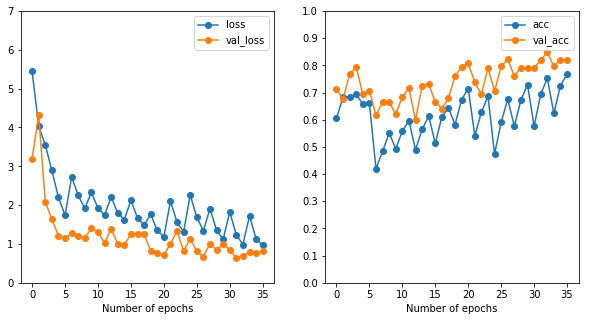

In [13]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

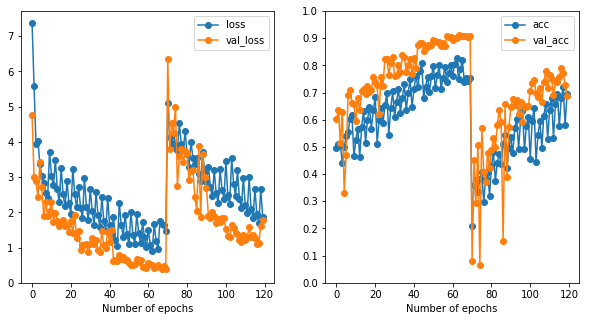

In [37]:

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.28.dogfacenet_v16.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.28.dogfacenet_v16.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

In [ ]:
for i in range(5):
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

    model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )

    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(i+16)+'.h5')

In [ ]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
history=model.fit(
    triplet_train,
    y_triplet_train,
    batch_size = 21*3,
    epochs = 1,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

In [ ]:
model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5')

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])
acc = np.append(acc,history.history['triplet_acc'])
val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
histories = []
nbof_cycles = 9
for i in range(0,nbof_cycles,1):

    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = nbof_cycles-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    
    histories += [history]
    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v10.hard_triplet_trained.data_aug.' + str(i+1) + '.h5')
    
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for i in range(len(histories)):
    history = histories[i]
    
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
# Test on new triplet integrity
print(new_y_triplet_train[-30:])
t = np.equal(new_y_triplet_train[0::3],new_y_triplet_train[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

In [ ]:
def shuffle_classes(images,labels):
    """
    Shuffles the classes
    """
    classes = np.unique(labels)
    np.random.shuffle(classes)
    
    shuffled_images = np.empty(images.shape)
    shuffled_labels = np.empty(labels.shape)
    idx = 0
    for i in range(len(classes)):
        keep_classes = np.equal(labels,classes[i])
        length = np.sum(keep_classes.astype(int))
        shuffled_labels[idx:idx+length] = labels[keep_classes]
        shuffled_images[idx:idx+length] = images[keep_classes]
        idx += length
    return shuffled_images, shuffled_labels

In [ ]:
def global_define_hard_triplets(images,labels,predict,datagen=datagen):
    """
    Generates hard triplet for offline selection. It will consider the whole dataset.
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict),h,w,c))
    y_triplets = np.empty(3*len(predict))
    
    idx_triplets = 0
    idx_images = 0
    
    for i in range(nbof_classes):
        keep_class = np.equal(labels,classes[i])
        mask_class = np.identity(len(predict)) * keep_class.astype(np.float32)
        
        #predict_class = mask_class.dot(predict)
        predict_other = np.copy(predict)
        for j in range(len(predict)):
            if keep_class[j]:
                predict_other[j] += np.inf
        
        keep_predict_class = predict[keep_class]
        
        for j in range(len(keep_predict_class)):
            # Computes the distance between the current vector and the vectors in the class
            dist_class = np.sum(np.square(keep_predict_class-keep_predict_class[j]),axis=-1)
            
            # Add the anchor
            triplets[idx_triplets] = single_apply_transform(images[idx_images+j],datagen)
            y_triplets[idx_triplets] = labels[idx_images+j]
            
            # Add the hard positive
            triplets[idx_triplets+1] = single_apply_transform(images[idx_images+np.argmax(dist_class)],datagen)
            y_triplets[idx_triplets+1] = labels[idx_images+np.argmax(dist_class)]
            
            # Computes the distance between the current vector and the vectors of the others classes
            dist_other = np.sum(np.square(predict_other-keep_predict_class[j]),axis=-1)
            
            # Add the hard negative
            triplets[idx_triplets+2] = single_apply_transform(images[np.argmin(dist_other)],datagen)
            y_triplets[idx_triplets+2] = labels[np.argmin(dist_other)]
            
            idx_triplets += 3
        
        idx_images += len(keep_predict_class)
        
    return triplets, y_triplets

In [ ]:
# Offline triplet selection:
# Generate hard triplets

def define_hard_triplets(images,labels,predict,class_subset_size=10, add=100*3):
    """
    Generates hard triplet for offline selection
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
        -class_subset_class: number of classes in a subset
        -
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict)+add*(nbof_classes//class_subset_size + 1),h,w,c))
    y_triplets = np.empty(3*len(predict)+add*(nbof_classes//class_subset_size + 1))
    idx = 0
    for i in tqdm_notebook(range(0,len(classes),class_subset_size)):
        selected_classes = classes[i:i+class_subset_size]
        keep_classes = np.array([labels[j] in selected_classes for j in range(len(labels))])
        
        selected_predict = predict[keep_classes]
        length = len(selected_predict)*3
        
        triplets_tmp,y_triplets_tmp = global_define_hard_triplets(
                                                                images[keep_classes],
                                                                labels[keep_classes],
                                                                selected_predict
                                                            )
        print(len(triplets_tmp))
        
        triplets[idx:idx+length] = triplets_tmp
        y_triplets[idx:idx+length] = y_triplets_tmp
        
        triplets[idx+length:idx+length+add], y_triplets[idx+length:idx+length+add] = define_triplets(images, labels, add)
        
        idx += len(triplets_tmp) + add
    return triplets, y_triplets

In [ ]:
lez = 30
n_images_train, n_labels_train = shuffle_classes(images_train[:lez],labels_train[:lez])

# Test
predict = model.predict(n_images_train)
# Takes a subset of classes:
_,idx_classes = np.unique(n_labels_train,return_index=True)
classes = n_labels_train[idx_classes]

# step1
selected_classes = classes[0:10]
keep_classes = np.array([n_labels_train[i] in selected_classes for i in range(len(n_labels_train))])

selected_predict = predict[keep_classes]
length = len(selected_predict)

im,lab1 = global_define_hard_triplets(n_images_train[keep_classes],n_labels_train[keep_classes],selected_predict)

In [ ]:
n_labels_train

In [ ]:
len(im)

In [ ]:
len(predict[keep_classes])

In [ ]:
print(lab1[-30:])
t = np.equal(lab1[0::3],lab1[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

In [ ]:
histories = []
n = 4
for i in range(n):
    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 24*3,
        epochs = n-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]
    triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
    triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)
    

In [ ]:
model.save(PATH_MODEL+'2019.02.08.dogfacenet_v9.emb_16.h5')

In [ ]:
history = histories[0]
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['triplet_acc']
val_acc = history.history['val_triplet_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
# np.save(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.npy',history_)
# np.savetxt(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Evaluate it

#### Evaluate on verification task

In [ ]:
NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = np.empty((NBOF_PAIRS*2,h,w,c))
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

In [ ]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)


best = 0
best_t = 0
thresholds = np.arange(0.0001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

### ROC curve

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Computes the ROC depending on different thresholds

thresholds = np.arange(0.0001,4,0.001)
tprs = np.empty(len(thresholds))
fprs = np.empty(len(thresholds))

p = np.sum(issame.astype(float))
n = np.sum(np.logical_not(issame).astype(float))

for i in range(len(thresholds)):
    logical_pred = np.less(dist, thresholds[i])
    tp = np.sum(np.logical_and(logical_pred,issame).astype(float))
    fp = np.sum(np.logical_and(logical_pred,np.logical_not(issame)).astype(float))
    tprs[i] = tp/p
    fprs[i] = fp/n
    
plt.figure(figsize=(7,7))
plt.plot(fprs,tprs)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")

### Face clustering

In [69]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [70]:
from sklearn.cluster import KMeans

In [76]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.3).fit(predict)

In [77]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

In [78]:
len(images_train)

2850

In [79]:
len(images_test)

298

In [ ]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        #fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn11.clustering.'+str(i)+'.png')

### Recognition: One-shot learning

In [67]:
pred_test = model.predict(images_test)

In [68]:
mean_acc = 0
nbof_try = 1000 # We will do many try on the test dataset to obtain a more precize accuracy

for k in tqdm_notebook(range(nbof_try)):
    nbof_kimages=int(0.8*len(np.unique(labels_test)))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)
    
    threshold = 0.3

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = np.argmin(dist)
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1

    acc /= len(others_pred)
    
    mean_acc += acc
    
mean_acc /= nbof_try
print("Mean accuracy for a one shot learner: " + str(mean_acc))


Mean accuracy for a one shot learner: 0.585688461538465


#### Test for one-shot learning:

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kimages=np.empty((nbof_kimages,h,w,c))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others = np.copy(images_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kimages[i] = others[keep_classes_images[choice]]
    
    others = np.delete(others,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

kpred = model.predict(kimages)

# Prediction for every other pictures
others_pred = model.predict(others)

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others_pred = np.copy(pred_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kpred[i] = others_pred[keep_classes_images[choice]]
    
    others_pred = np.delete(others_pred,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

In [ ]:
# we will use the best threshold find on verification task
threshold = 0.3

# for i in range(len(others_pred)):

acc = 0

class_pred = np.empty(len(others_pred))

for i in range(len(others_pred)):
    # computes distance with the key dataset
    dist = np.sum(np.square(kpred-others_pred[i]),1)
    if np.min(dist) < threshold:
        class_pred[i] = np.argmin(dist)
        if np.argmin(dist)==y_others[i]:
            acc += 1
    else:
        class_pred[i] = -1
        if not y_others[i] in y_kimages:
            acc += 1
        
acc /= len(others_pred)
acc

In [ ]:
# we will use the best threshold find on verification task
best_acc = 0
best_t = 0.001
for threshold in np.arange(0.001,1,0.001):

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = np.argmin(dist)
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1
    acc /= len(others_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_t = threshold


print(best_acc)
print(best_t)

In [ ]:
plt.figure(figsize=(8,5))
for i in range(38):
    plt.subplot(5,8,i+1)
    plt.imshow(kimages[i])

In [ ]:
plt.figure(figsize=(13,18))
for i in range(13*18):
    plt.subplot(18,13,i+1)
    plt.imshow(others[i])

### Recognition: K-NN

In [ ]:
def find_n_mins(t,n):
    idx_mins = []
    mins = []
    for i in range(n):
        idx_crt_min = 0
        crt_min = t[0]
        for j in range(1,len(t)):
            if t[j] < crt_min:
                crt_min = t[j]
                idx_crt_min = j
        idx_mins += [idx_crt_min]
        mins += [crt_min]
        t = t[:idx_crt_min] + t[idx_crt_min+1:]
    return idx_mins, mins

In [ ]:
k = 2

nbof_kimages=int(0.8*len(np.unique(labels_test)))
kpred=np.empty((nbof_kimages*k,pred_test.shape[-1]))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others_pred = np.copy(pred_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choices = np.empty(k)
    for j in range(k):
        choice = np.random.randint(len(keep_classes_images))
        if k > len(keep_classes_images):
            choices[j] = choice
        else:
            while choice in choices:
                choice  = np.random.randint(len(keep_classes_images))
            choices[j] = choice
    
    
    for choice in choices:
        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)

threshold = 0.3

acc = 0

class_pred = np.empty(len(others_pred))

for i in range(len(others_pred)):
    # computes distance with the key dataset
    dist = np.sum(np.square(kpred-others_pred[i]),1)
    if np.min(dist) < threshold:
        class_pred[i] = np.argmin(dist)
        
        idx_mins,_ = find_n_mins(dist,k+1)
        if len(np.unique(idx_mins)) == k+1:
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            # Find the most probable class
            ccount
            for 
    else:
        class_pred[i] = -1
        if not y_others[i] in y_kimages:
            acc += 1

acc /= len(others_pred)

mean_acc += acc
    

### Recognition: Re-training

In [ ]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [ ]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [ ]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [ ]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=30)

### Observation on the heatmap

In [ ]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

In [ ]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

### Archives:

In [ ]:
# dogfacenet_v7
out_num = len(unique)

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Lambda

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(104, 104, 3))
x = base_model.output
# x = base_model.layers[8].output
# x = MaxPooling2D((2,2))(x)
# x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(18)(x)
x = Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

In [ ]:
triplet_train_pre = tf.keras.applications.vgg16.preprocess_input(triplet_train)

In [ ]:
history=model.fit(
    triplet_train_pre,
    np.zeros((len(triplet_train),18)),
    batch_size = 63,
    epochs = 100,
    validation_split=0.1
)

In [ ]:
# dogfacenet_v8 : inspired from FaceNet paper
emb_size = 64

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(64, (5, 5), strides=(2,2), activation='relu', input_shape=(104, 104, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x)))

model.compile(loss=triplet,
              optimizer='adagrad',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v4
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

In [ ]:
model.save('../output/model/dogfacenet_v6_cosine.h5')